In [1]:
import xarray as xr
import os
import fsspec
from datetime import datetime


In [2]:
path = '/work/users/jn906hluu/S2_Frankenwald_zarr'

In [49]:
list_of_dir = [os.path.join(folder) for folder in os.scandir(path)]

In [50]:
len(list_of_dir)

312

In [5]:
ds = xr.open_zarr(fsspec.get_mapper(), \
                  consolidated=True)

In [53]:
list_of_dir.sort()
list_of_xarray_datasets = []
count_failed = 0

for file in list_of_dir:
    date = file.split('/')[-1].split('.')[0]
    dt = datetime.strptime(date, '%Y-%m-%d')
    try:
        ds = xr.open_zarr(fsspec.get_mapper(file), consolidated=True)
        ds = ds.assign_coords({'time' : dt})
        ds = ds.sel(band=slice(1,12))
        ds['refl'] = ds['refl'].where(ds.mask)
        list_of_xarray_datasets.append(ds)
    except:
        #print(f'Failed to load dataset {date}')
        count_failed += 1
print(count_failed / len(list_of_dir))

0.0


In [54]:
ds

<xarray.Dataset>
Dimensions:  (band: 12, lat: 7530, lon: 11540)
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 50.97 50.97 50.97 50.97 ... 50.31 50.31 50.31 50.31
  * lon      (lon) float64 10.29 10.29 10.29 10.29 ... 11.96 11.96 11.96 11.96
    time     datetime64[ns] 2022-12-18
Data variables:
    mask     (lat, lon) bool dask.array<chunksize=(942, 1443), meta=np.ndarray>
    refl     (band, lat, lon) float64 dask.array<chunksize=(1, 471, 1443), meta=np.ndarray>
Attributes:
    author:                       Joshua Müller
    band_dimension:               bands
    coordinate_reference_system:  EPSG:4326
    creation_date:                2023-02-12
    platform:                     Sentinel-2
    product_type:                 Level-2A
    projection:                   Geographic
    resolution:                   10
    wavelength_units:             nanometers
    wavelengths:                  [443, 490, 560, 665, 705, 740, 783, 842, 94...

In [28]:
combined_set = xr.concat(list_of_xarray_datasets, dim='time')

In [29]:
resampled_set = combined_set.resample(time='1M').mean()

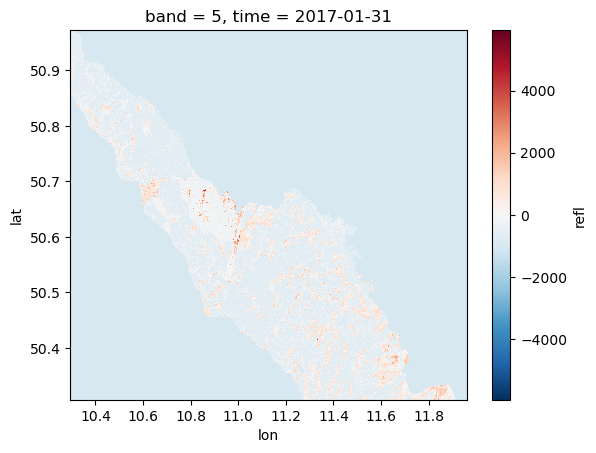

In [30]:
resampled_set.sel(band=5).isel(time=0).refl.plot()

In [31]:
resampled_set

<xarray.Dataset>
Dimensions:  (band: 13, lat: 7530, lon: 11540, time: 72)
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
  * lat      (lat) float64 50.97 50.97 50.97 50.97 ... 50.31 50.31 50.31 50.31
  * lon      (lon) float64 10.29 10.29 10.29 10.29 ... 11.96 11.96 11.96 11.96
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2022-12-31
Data variables:
    mask     (time, lat, lon) float64 dask.array<chunksize=(1, 942, 1443), meta=np.ndarray>
    refl     (time, band, lat, lon) float64 dask.array<chunksize=(1, 1, 471, 1443), meta=np.ndarray>
Attributes:
    author:                       Joshua Müller
    band_dimension:               bands
    coordinate_reference_system:  EPSG:4326
    creation_date:                2023-02-12
    platform:                     Sentinel-2
    product_type:                 Level-2A
    projection:                   Geographic
    resolution:                   10
    wavelength_units:             nanometers
    wavelengths:                  [443, 490, 560, 665, 705, 740, 783, 842, 94...

In [45]:
pr_ds = xr.open_dataset('/work/users/jn906hluu/Climate/Precipitation/pr_hyras_1_2022_v5-0_de.nc')

In [46]:
pr_ds

<xarray.Dataset>
Dimensions:             (time: 365, bnds: 2, y: 1100, x: 1200)
Coordinates:
  * time                (time) datetime64[ns] 2022-01-01T18:00:00 ... 2022-12...
    lon                 (y, x) float64 ...
    lat                 (y, x) float64 ...
  * x                   (x) float32 3.5e+06 3.502e+06 ... 4.698e+06 4.7e+06
  * y                   (y) float32 2.1e+06 2.102e+06 ... 3.198e+06 3.2e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    x_bnds              (x, bnds) float32 ...
    y_bnds              (y, bnds) float32 ...
    crs_HYRAS           int32 ...
    pr                  (time, y, x) float32 ...
    number_of_stations  (time) float64 ...
Attributes: (12/20)
    Conventions:               CF-1.8
    source:                    surface observations
    institution:               Deutscher Wetterdienst (DWD)
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    ...                        ...
    conventionsURL:            http://cfconventions.org/Data/cf-conventions/c...
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    input_data_status:         checked
    filename:                  pr_hyras_1_2022_v5-0_de.nc
    creation_date:             created at 2023-01-15 08:18:28
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5-0_2022_day_0063C3B6D4

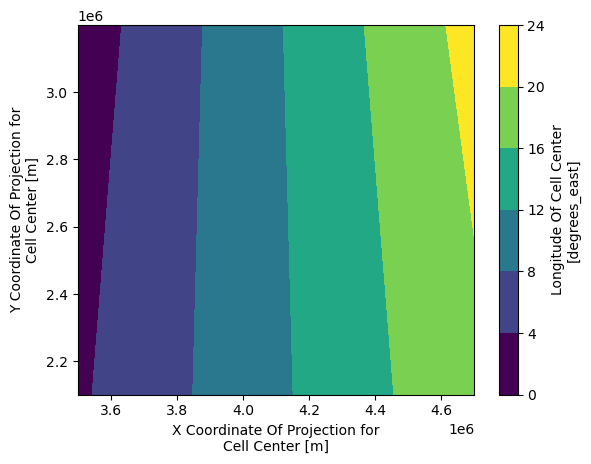

In [17]:
pr_ds.sel(lat=slice(ds.lat[0], ds.lat[-1]), lon=slice(ds.lon[0], ds.lon[-1]))

KeyError: "no index found for coordinate 'lat'"